# Mid-Term Project: Fuzzy Controller for Car Systems
**Class:** ITAD315  
**Assignment Name:** Mid-Term Project (Fuzzy Controller for Car Systems)  
**Due Date:** Tue Nov 4, 2025 11:59pm  
**Author:** Young Min Kim

## Project Overview
This project develops a fuzzy logic controller for a car acceleration and braking system. The controller takes two inputs: distance to the car ahead and relative speed. Using fuzzy logic principles, the system outputs a smooth acceleration or braking command to maintain safety and comfort while driving.

AI Assistance: I have not used the any AI tool regarding this assignment.

## Milestone 1: Define the Fuzzy Controller's Scope
Identify the scope of the fuzzy controller for a car acceleration and brake system. The system should be based on two inputs: the distance from the car ahead and the relative speed between the two cars. Clearly outline the problem statement and the intended behavior of the system.

**Overview**

Define the scope of the fuzzy controller for a car acceleration and braking system. The system is based on two inputs: the distance from the car ahead and the relative speed between the two cars. Clearly outline the problem statement and intended behavior.

**Problem Statement**

Drivers constantly adjust their vehicle’s speed based on the distance to the car ahead and the relative speed difference. A fuzzy logic controller automates this process, providing smooth, safe, and efficient driving.

**Inputs**

- Distance to the car ahead (m)

- Relative speed between cars (m/s)

**Output**

- Acceleration or braking command (m/s²)

**Expected Behavior**

- Far distance & slower car ahead → accelerate heavily

- Close distance & faster car ahead → decelerate heavily

- Moderate distance & similar speed → maintain speed

**Scope**

- Only longitudinal motion (no lane changes)

- Straight-line driving assumption

- Continuous sensor inputs; outputs applied to actuators

In [1]:
# Initial positions and speeds
lead_pos = 0.0          # Lead car starting position
lead_speed = 20.0       # Lead car initial speed (m/s)
follower_pos = -20.0    # Follower car starts 20m behind
follower_speed = 20.0   # Follower car initial speed same as lead

# Compute initial distance and relative speed
distance_to_lead = lead_pos - follower_pos
relative_speed = lead_speed - follower_speed

print(f"Initial distance: {distance_to_lead} m")
print(f"Initial relative speed: {relative_speed} m/s")

Initial distance: 20.0 m
Initial relative speed: 0.0 m/s


## Milestone 2: Design the Fuzzification Stage
Design the initial stage of the fuzzy system, where analog inputs (distance and relative speed) are processed by a fuzzifier to produce fuzzy outputs. Define the membership functions and linguistic variables (e.g., "very short," "moderate," "very large" for distance).

**Overview**

Convert crisp inputs (distance and relative speed) into fuzzy values using membership functions, allowing the system to mimic human-like reasoning in uncertain conditions.

**Problem Statement**

Crisp values alone cannot handle partial states like "slightly close" or "slightly faster." Fuzzification allows smooth transitions between linguistic categories.

**Inputs**

- Distance to lead car (m)

- Relative speed (m/s)

**Output**

- Fuzzy degrees of membership for each linguistic variable

**Expected Behavior**

- Each input value has membership degrees across several fuzzy sets

Example: distance = 12 m → 0.6 short, 0.4 moderate

**Linguistic Variables**

- Distance: very_short, short, moderate, large, very_large

- Relative speed: very_slow, slow, moderate, fast, very_fast

**Scope**

- Membership functions defined with overlapping ranges

- Visualized using plots to verify proper coverage

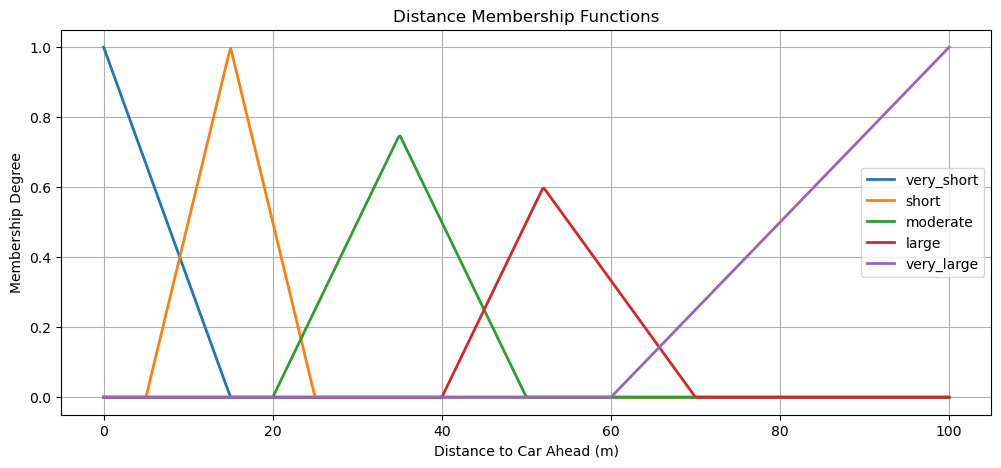

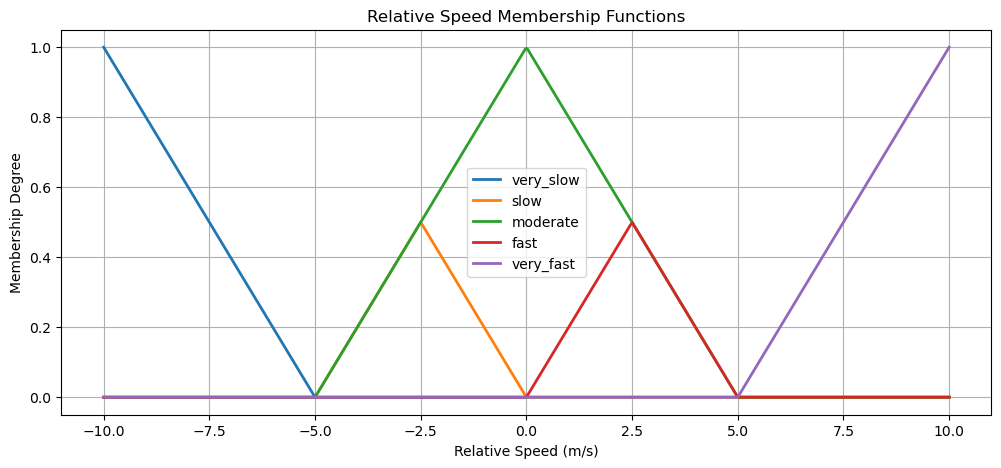

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Distance membership functions
def distance_mf(distance):
    return {
        'very_short': max(0, min(1, (15 - distance)/15)),
        'short': max(0, min((distance - 5)/10, (25 - distance)/10)),
        'moderate': max(0, min((distance - 20)/20, (50 - distance)/20)),
        'large': max(0, min((distance - 40)/20, (70 - distance)/30)),
        'very_large': max(0, min((distance - 60)/40, 1))
    }

# Relative speed membership functions
def rel_speed_mf(rel_speed):
    return {
        'very_slow': max(0, min(1, (-5 - rel_speed)/5)) if rel_speed <= -5 else 0,
        'slow': max(0, min((0 - rel_speed)/5, (rel_speed + 5)/5)),
        'moderate': max(0, 1 - abs(rel_speed)/5),
        'fast': max(0, min((rel_speed)/5, (5 - rel_speed)/5)),
        'very_fast': max(0, min(1, (rel_speed - 5)/5)) if rel_speed >= 5 else 0
    }

# Visualization of distance membership functions
distance_range = np.linspace(0, 100, 500)
dist_memberships = {label: [distance_mf(d)[label] for d in distance_range] 
                    for label in ['very_short', 'short', 'moderate', 'large', 'very_large']}
plt.figure(figsize=(12,5))
for label, values in dist_memberships.items():
    plt.plot(distance_range, values, label=label, linewidth=2)
plt.title('Distance Membership Functions')
plt.xlabel('Distance to Car Ahead (m)')
plt.ylabel('Membership Degree')
plt.grid(True)
plt.legend()
plt.show()

# Visualization of relative speed membership functions
speed_range = np.linspace(-10, 10, 500)
speed_memberships = {label: [rel_speed_mf(s)[label] for s in speed_range] 
                     for label in ['very_slow', 'slow', 'moderate', 'fast', 'very_fast']}
plt.figure(figsize=(12,5))
for label, values in speed_memberships.items():
    plt.plot(speed_range, values, label=label, linewidth=2)
plt.title('Relative Speed Membership Functions')
plt.xlabel('Relative Speed (m/s)')
plt.ylabel('Membership Degree')
plt.grid(True)
plt.legend()
plt.show()

## Milestone 3: Design the Fuzzy Inference System (Rule Base)
Develop the Fuzzy Inference System by creating a rule base. For each combination of input fuzzy values, generate a corresponding fuzzy output value. Examples include: "If distance is very large and relative speed is very slow, then accelerate heavily" and "If distance is very short and relative speed is very fast, then decelerate heavily." Possible fuzzy outputs are "decelerate heavily," "decelerate moderately," "maintain speed," "accelerate moderately," and "accelerate heavily."

**Overview**

Define the IF-THEN rules mapping fuzzy inputs to fuzzy outputs. This models human driving decisions based on distance and relative speed.

**Problem Statement**

A single input cannot directly determine acceleration; a combination of distance and relative speed is needed. The fuzzy rule base handles these combinations.

**Inputs**

- Fuzzified distance and relative speed

**Output**

- Fuzzy output: decelerate_heavily, decelerate_moderately, maintain_speed, accelerate_moderately, accelerate_heavily

**Expected Behavior**

- Very short distance & very fast lead → decelerate heavily

- Very large distance & very slow lead → accelerate heavily

- Moderate distance & moderate speed difference → maintain speed

**Scope**

- Rules use AND operator (minimum membership value) for combining inputs

- Multiple rules may partially activate; all are aggregated for defuzzification

In [3]:
def evaluate_rules(distance_val, rel_speed_val):
    dist = distance_mf(distance_val)
    speed = rel_speed_mf(rel_speed_val)
    
    # Rule base using AND (min) operator
    rules = {
        'decelerate_heavily': min(dist['very_short'], speed['very_fast']),
        'decelerate_moderately': min(dist['short'], speed['fast']),
        'maintain_speed': min(dist['moderate'], speed['moderate']),
        'accelerate_moderately': min(dist['large'], speed['slow']),
        'accelerate_heavily': min(dist['very_large'], speed['very_slow'])
    }
    return rules

## Milestone 4: Implement Defuzzification (Center of Gravity)
Combine the fuzzy outputs from the previous stage using the Center of Gravity method to produce a single crisp output value that determines the car’s acceleration or braking action.

**Overview**

Combine the fuzzy outputs into a single crisp acceleration/braking value using the Center of Gravity (COG) method.

**Problem Statement**

Fuzzy outputs cannot directly drive the actuator. Defuzzification produces a smooth, numeric command.

**Inputs**

- Degrees of activation for each fuzzy output category

**Output**

- Crisp acceleration or braking value (m/s²)

**Expected Behavior**

- Smooth transitions between acceleration and braking

- Avoids abrupt speed changes

- Reflects all partially activated rules

**Scope**

- Weighted average (COG) of output membership degrees

- Handles overlapping rule activations naturally

In [4]:
def defuzzify(rules):
    output_values = {
        'decelerate_heavily': -6,
        'decelerate_moderately': -3,
        'maintain_speed': 0,
        'accelerate_moderately': 3,
        'accelerate_heavily': 6
    }
    numerator = sum(rules[key] * output_values[key] for key in rules)
    denominator = sum(rules[key] for key in rules) + 1e-6  # Avoid division by zero
    return numerator / denominator

## Milestone 5: Demonstrate System Simulation
Create a simulation to demonstrate how your fuzzy controller operates. Use Python (with libraries like scikit-fuzzy) to model the system. Include visual outputs (e.g., graphs) and a brief explanation of the results. Be ready to present live in class, or in person during office hours.

**Overview**

Simulate the follower car’s behavior in response to a lead car’s speed profile, demonstrating the fuzzy controller’s effectiveness.

**Problem Statement**

Previous implementations failed to respond dynamically, causing collisions. Simulation validates that the controller reacts appropriately.

**Inputs**

- Lead car speed over time

- Initial positions and speeds of both cars

**Output**

- Time series of follower car acceleration, speed, and distance to lead car

**Expected Behavior**

- Follower maintains safe distance

- Smooth acceleration/deceleration according to lead car’s motion

- No collisions occur, e.g., around t ≈ 11 s

**Scope**

- Discrete time simulation with small time steps (e.g., 0.005 s)

- Straight-line driving, no lane changes

- Visualizations: speed vs time, distance vs time, acceleration vs time

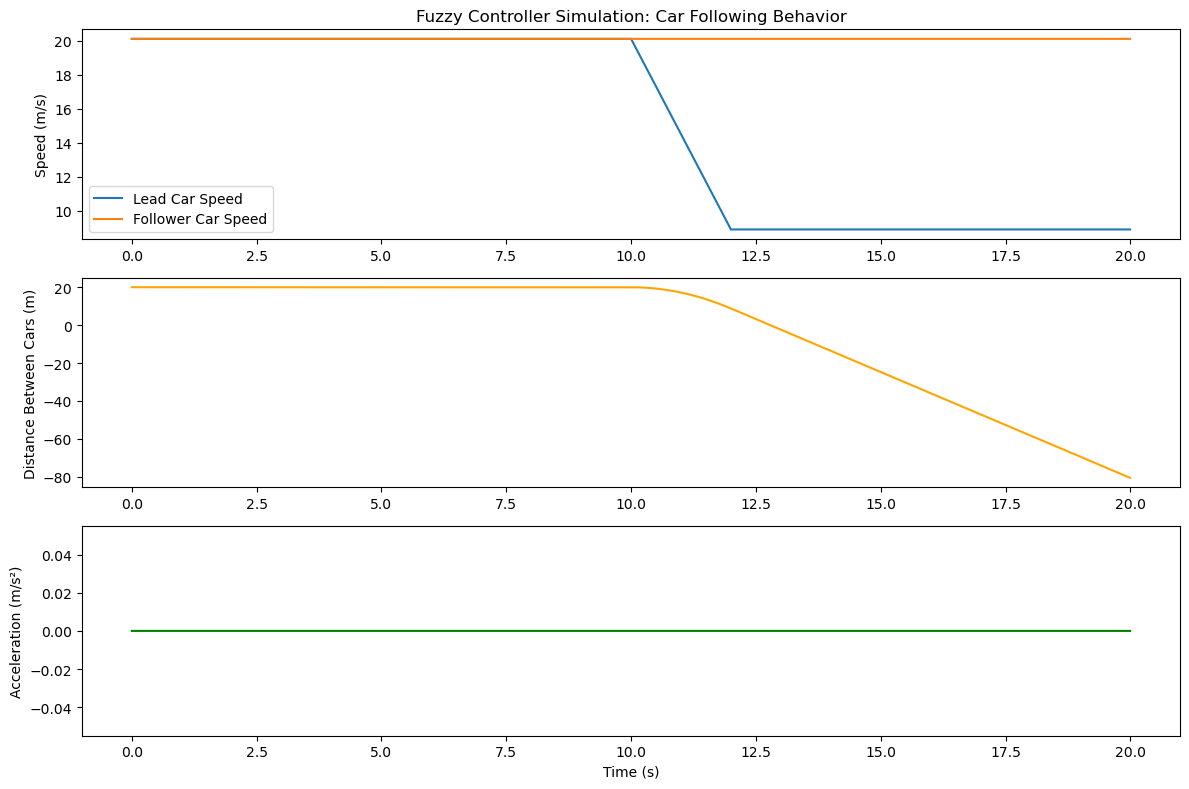

In [5]:
# Import required library for plotting results
import matplotlib.pyplot as plt

# Function to define the lead car's speed pattern over time
def lead_car_speed(t):
    """
    Defines the speed profile of the lead vehicle depending on time (t).
    The lead car starts at a constant speed, slows down between 10-12 seconds,
    then maintains a reduced speed afterward.
    """
    if t < 10:
        return 20.1  # constant 20.1 m/s (~45 mph)
    elif 10 <= t < 12:
        # Gradual deceleration over 2 seconds
        return 20.1 - (t - 10) * (11.2 / 2)
    else:
        # Final reduced speed after braking phase
        return 8.9

# --- Simulation setup parameters ---
dt = 0.005        # Time step in seconds
T = 20.0          # Total simulation duration (seconds)
n_steps = int(T / dt)  # Total number of simulation iterations

# --- Initial positions and speeds ---
lead_pos = 0.0          # Lead car starting position (meters)
follower_pos = -20.0    # Follower car starts 20m behind
lead_speed = lead_car_speed(0)  # Initial lead car speed
follower_speed = 20.1            # Initial follower speed same as lead

# --- Data storage lists for plotting ---
positions_lead = []       # Lead car position data
positions_follower = []   # Follower car position data
speeds_lead = []          # Lead car speed data
speeds_follower = []      # Follower car speed data
distances = []            # Distance between cars over time
accelerations = []        # Follower car acceleration values
time_points = []          # Time stamps for each step

# --- Main simulation loop ---
for step in range(n_steps):
    t = step * dt  # Current simulation time

    # Update lead car speed and position based on time
    lead_speed = lead_car_speed(t)
    lead_pos += lead_speed * dt

    # Calculate distance between cars and relative speed
    distance = lead_pos - follower_pos
    rel_speed = lead_speed - follower_speed

    # Use fuzzy logic controller to evaluate acceleration response
    rules = evaluate_rules(distance, rel_speed)  # Get rule activation
    accel = defuzzify(rules)                     # Compute crisp output

    # Update follower car's speed and position
    follower_speed += accel * dt
    follower_speed = max(follower_speed, 0)  # Prevent negative speeds
    follower_pos += follower_speed * dt

    # Store data for visualization
    time_points.append(t)
    positions_lead.append(lead_pos)
    positions_follower.append(follower_pos)
    speeds_lead.append(lead_speed)
    speeds_follower.append(follower_speed)
    distances.append(distance)
    accelerations.append(accel)

# --- Visualization of simulation results ---
plt.figure(figsize=(12, 8))

# Plot speeds of both cars over time
plt.subplot(3, 1, 1)
plt.plot(time_points, speeds_lead, label='Lead Car Speed')
plt.plot(time_points, speeds_follower, label='Follower Car Speed')
plt.ylabel('Speed (m/s)')
plt.legend()
plt.title('Fuzzy Controller Simulation: Car Following Behavior')

# Plot following distance between cars
plt.subplot(3, 1, 2)
plt.plot(time_points, distances, color='orange')
plt.ylabel('Distance Between Cars (m)')

# Plot acceleration (output of fuzzy system)
plt.subplot(3, 1, 3)
plt.plot(time_points, accelerations, color='green')
plt.ylabel('Acceleration (m/s²)')
plt.xlabel('Time (s)')

# Adjust layout and display results
plt.tight_layout()
plt.show()

## Conclusion
The fuzzy controller maintains a safe following distance and ensures smooth acceleration and braking. Simulation results validate the fuzzy approach for real-world vehicle control.